WARNING! For running this notebook, its better to download it and run it outside of GitHub, as GitHub is not able to use some libraries (for example print Folium maps). Also it is required to install packages geocoder,folium,requests,pandas,numpy,sklearn and some others (mentioned in next cell)

In [1]:
#install these libraries if you do not have them
!@echo off pip install geocoder folium requests pandas numpy sklearn geopy shapely lxml matplotlib

off pip install geocoder folium requests pandas numpy sklearn geopy shapely lxml matplotlib


# Apartment house for seniors in Prague
Prague is city in Czech republic (country in central Europe). Like all other countries in Europe, average age in population is slowly increasing over decades. This continuous change creates a requirement for more services for elderly people, such as pharmacies, hospitals, parks, and so on. This also includes a problem with housing and living. Many apartments are in buildings without elevators, sometimes there are no close stores, or even no public transport stations.

Fortunately, there are projects, companies, and people, who want to offer decent living posibilities for seniors. There are many retirement homes and apartment houses for elderly people in the country, and they make their living much easier, because they are built with respect to needs of these people. This means there is elevator, enough nature around, it's not located in busy parts of cities, and so on.

Let's say there is fictional real estate development company which wants to build a new apartment house in Prague, which will be designed especially for elderly people. __In this project, I will analyze different parts of Prague, using Foursquare API, information from Wikipedia, and data from OpenStreetMaps, to find out potentionally good places for building new apartment house for seniors__. I will use different criteria, which I consider important.

_Please take into account, that this project is simplified and inlcudes only some basic criteria, thus it does not reflect whole reality._

## Usage of data in planning
For our project, I decided to set several criteria, which may be important for analysis of different district in Prague. But before that, we need to decide how to determine what is _part of Prague_. 

### Dividing city into different neighborhoods / districts

On Wikipedia (https://en.wikipedia.org/wiki/Districts_of_Prague) we can find list of districts in Prague. From what we can see, Prague can be split into different districts or neighborhoods in three different ways:
 - Administrative districts: Prague is divided into 22 parts administrative parts which are named very simply: Prague 1, Prague 2, Prague 3,... ,Prague 22. This type of division is sometimes only formal, because it includes huge areas, so it's not very precise.
 - Municipal districts: Prague can be divided also to 57 parts, which is more precise.
 - Cadastral areas: There are 111 cadastral areas in Prague, which is even more precise, and best fits the purpose of my analysis.
 
For our purpose, it is best to use Cadastral areas, as they are smaller (thus more precise) than Administrative or Municipal districts.

### Selecting our criteria
As our criteria I decided to ask following questions, about each district:

 - How much is the district good for relaxation? Usually elderly people prefers calm and clean environment
     - What is the size of nature areas (forests, parks,...) available to public in the district? (available on OpenStreetMaps)
     - How many clubs, bars and hotels are in the district? These places usually attract people who wants to enjoy their free time, so there could be problems with noise and some conflicts in streets, parks, and so on. This data is also available on Foursquare.
     - Also what is the population density - more people means usually more noise. This is available on Wikipedia
     - Sometimes there can be lot of industrial areas that may be also noisy. This is available in OpenStreetMaps
 - How much is the district suitable in terms of public services? For elderly people it's especially important to have everything they need in their district.
     - How many hospitals, pharmacies, and clinics are in the district? (available on Foursquare)
     - How many stores and supermarkets are in the district? (available on Foursquare)
     - Is there any public transport (tram or subway) station? (available on Foursquare)
     
There is more criteria which could be considered, but for purpose of our project, these should be enough.

----------------------------------------------------

## Technical part of the project
In this part, I do all the work, which is needed to get to some conclusion. In the end, there should be list of districts, which are most suitable for building a new apartment house for seniors.

### 1) Import necessary libraries
First we need to import some basic libraries we are gonna use.


In [2]:
import io
import pickle
import folium    #showing the maps
import requests    #getting data from wiki
import pandas as pd    #doing analysis
import numpy as np    #doing analysis
import geocoder    #getting data from ArcGis
import re    #renaming districts from wiki correctly
from sklearn.cluster import KMeans    #KMeans clustering
from sklearn.cluster import AgglomerativeClustering as AC #Agglomerative clustering
from sklearn.metrics import silhouette_score    #scoring model, selecting features
from IPython.display import display    #showing some important outputs
import unicodedata    #encoding texts for folium 
from lxml import etree    #parsing data from wiki
from sklearn.preprocessing import RobustScaler    #preparing data for clustering
import matplotlib.pyplot as plt    #showing charts
import geopy.distance    #import formula to calculate distances based on coordinates
from shapely.geometry import Point    #shapely libraries will be used for some geometric operations with maps
from shapely.geometry import Polygon
from math import floor
from itertools import product

### 2)  Getting list of districts from wiki
We need to get the data. If you open the link in description of the project, you can see there is table with all municipal districts in Prague. We will use it. Don't worry it's in czech, there is no need to understand it (only header, but I will translate that in following cell)

In [3]:
PrgDistrictsLink = 'https://cs.wikipedia.org/wiki/Seznam_katastr%C3%A1ln%C3%ADch_%C3%BAzem%C3%AD_v_Praze'
data = pd.read_html(PrgDistrictsLink)

#because read_html returns list of dataframes, we want to select the first dataframe which represents table with districts
data = data[0]

#as header of table is in Czech, lets translate it to english.
data.columns = ['Index','Cadastral area','Census 2001','Census 2011','Census 2014','Area (ha)','Population density (km2)']

#show output
data.head()

,Index,Cadastral area,Census 2001,Census 2011,Census 2014,Area (ha),Population density (km2)
0,1,Stodůlky,52 101,59 711,61 105,962,6 351
1,2,Žižkov,55 401,55 691,56 829,544,10 443
2,3,Chodov,58 140,54 659,53 771,743,7 237
3,4,Vinohrady,54 516,50 720,50 751,379,13 401
4,5,Vršovice,36 345,37 066,35 930,293,12 243


Now we will keep in dataframe only Cadastral area name, and population density

In [4]:
#getting districts, keep only name and population density
districts = data[['Cadastral area','Population density (km2)']]
districts.head()

,Cadastral area,Population density (km2)
0,Stodůlky,6 351
1,Žižkov,10 443
2,Chodov,7 237
3,Vinohrady,13 401
4,Vršovice,12 243


We will also define function, which removes special czech punctation (or diacritics). This will be used especially for showing places on maps, as Folium library has problems with these characters

In [5]:
#following function just removes characters like š,č,ř,... and replaces them with simple ones
def rem_dia(string):
    return unicodedata.normalize('NFD',string).encode('ascii','ignore').decode()

rem_dia('Žižkov')

'Zizkov'

### 3) Adding coordinates to each district
Now we need to get points that define each district as a polygon. For that we will use OpenStreetMaps, which can provide this data using Overpass API. However, it does not provide just list of points for given district. When you do a call for API it provide list of _ways_. Each way is list of points. You can connect these points inside one _way_ - they are already sorted. Unfortunatelly, ways are not sorted. That means, that you don't know, which way should be after which other.

For this reason, I created function _get_district_polygon_ which basically downloads all ways and connect them. For each _way_ it will try to find another _way_ which has closest starting point to ending point of current _way_. This is procedure which allows us to generate list of points in correct order and then make polygon from them.

In [6]:
def get_dist(A,B):
    return (((A[1]-B[1])**2)+((A[0]-B[0])**2))**(1/2)
    
def get_district_polygon(dist,boundary):
    """
    get polygon of given district by its name.
    dist: string, name of district
    boundary: string: lat1,lon1,lat2,lon2. Defines bounding box where district is searched.
    """
    #download data
    print('downloading data for district {}'.format(dist+' '*100),end='\r')
    osmurl = "https://lz4.overpass-api.de/api/interpreter"
    pst = """relation[name="{}"][type="boundary"]({});out geom;""".format(dist,boundary)
    osmdata = requests.post(url=osmurl,data={'data':pst})
    parsed = etree.XML(osmdata.content) #osmdata.content returns bytes - thats needed for etree parser
    
    #district is determined by multiple ways objects, that are related. These objects are 'members'. Let's extract them.
    #Also let's save first and last point of each way separatedly.
    membs_border_points = []
    membs_points = []
    for member in parsed.xpath('//member'):
        latlng = [(float(point.attrib['lat']),float(point.attrib['lon'])) for point in member.getchildren()]
        if len(latlng) >= 2:
            membs_border_points.append({'start':latlng[0],'end':latlng[-1]})
            membs_points.append(latlng)
            
    #if there is only one way which defines whole district, then it's returned directly
    if len(membs_points) == 1:
        return membs_points[0]
    
    #if there are multiple ways, sort them. Start with the first one, then find out which way should be following and so on.    
    final_points = []
    used_members = set({0})
    curr_member = membs_points[0]
    
    #iterate until there are some ways that were not used
    while True:
        
        #add each point of current way to final polygon
        for point in curr_member:
            final_points.append(point)
        last_point = final_points[-1]

        #get the way which's starting or ending point has lowest distance to last point in current way
        lowest_distance = 1000
        for idx,stp in enumerate(membs_border_points):
            
            #check only ways that are not added to final output yet
            if idx not in used_members:
                stdist = get_dist(stp['start'],last_point)
                ltdist = get_dist(stp['end'],last_point)
                dist = min(stdist,ltdist)
                if dist < lowest_distance:
                    lowest_distance = dist
                    nextCurr = idx
                    if dist == stdist:
                        reverse = False
                    else:
                        reverse = True

        #set next way and determine whether it should be reversed or not
        curr_member = list(membs_points[nextCurr])
        if reverse == True:
            curr_member = [curr_member[-i-1] for i in range(len(curr_member))]

        #check whether there are still some unused ways, mark next way as used
        if len(used_members) == len(membs_points):
            break
        used_members.add(nextCurr)

    return final_points

Now we can use _get_district_polygon_ to get polygon of given district inside given area. This area is given by _Prague_bbox_ variable

__Because this operation takes lot of time (downloading and processing lot of data) I already presaved downloaded data to my github folder, where it will be loaded from in next cell. You can note that original code in next cell is commented out.__

In [7]:
Prague_bbox = "49.9419006, 14.224435, 50.173, 14.7067867"

#get coordinates for all districts
#districts['polygon'] = districts['Cadastral area'].apply(lambda x: get_district_polygon(x,Prague_bbox))
districts = pd.read_pickle('https://github.com/japolo95/Coursera_Capstone/blob/master/Final_Assignment/districts_polygons.pkl?raw=true').reset_index()

We downloaded polygons of all districts, now we can plot them on map. Also, when you hoover over each polygon, you will see name of that district

In [8]:
fmap = folium.Map(location=('50.1','14.44'),zoom_start=14)
for polygon,dist in zip(districts['polygon'],districts['Cadastral area']):
    poly = folium.vector_layers.Polygon(polygon,color='black',tooltip=rem_dia(dist),fill=True,fillcolor='gray')
    poly.add_to(fmap)
fmap

In [9]:
#append population density back
districts['citiziens/km2'] = districts['Population density (km2)'].apply(lambda x: int(x.replace('\xa0','')))

#set district name as index
districts.set_index('Cadastral area',inplace=True)

#show result
districts.head()

,Population density (km2),polygon,citiziens/km2
Cadastral area,,,
Stodůlky,6 351,"[(50.0316792, 14.3357763), (50.031727, 14.3358...",6351
Žižkov,10 443,"[(50.0971263, 14.4787901), (50.0973752, 14.478...",10443
Chodov,7 237,"[(50.0233785, 14.5237327), (50.0234259, 14.523...",7237
Vinohrady,13 401,"[(50.07245, 14.4848259), (50.0726444, 14.48652...",13401
Vršovice,12 243,"[(50.0619734, 14.4528702), (50.0619775, 14.452...",12243


### 4) Getting the data about each district
Now we need to get important data which we want to know, about each district.
 - Some data, like location or population density are already downloaded from Wikipedia.
 - Data about venues like stores, hospitals, and so on, will be downloaded using Foursquare API.
 - Data about sizes of forests, industrial zones, etc. will be downloaded using OpenStreetMaps.

#### 4.1) Getting venues data from Foursquare API
Here we use Foursquare API to get information about number of different venues in each district. I already mentioned it in the beginning, but to conclude it we are looking for:
 - Bars, Clubs, and night life venues
 - Pharmacies, hospitals, stores
 - Public transport stations
 
 
---


At first, we need to define categories of venues we want to search for. Fortunately, Foursquare has its own documentation, where each specific venue, has different category. Also it allows in one API call, to call more different types of venues. We will create custom groups of venues. Firstly, here is an example of category with supermarkets (foodstores)

In [10]:
#define categories from foursquare, by the API ID
foodstores = '4bf58dd8d48988d1f9941735'

Now we create function, which will find these venues in given location, using Foursquare API.

In [11]:
#prepare foursquare client id and client secret
client_id = 'AJTAE4Q4HU5CGMLDWUJI1EAZMC1UMQ1K24MRTVQRXXWYZSYS'
client_secret = 'SIDVGKLWPPXTGQ0JJCLHUA220CXYITS2CO534PGVCHKFP2H2'

#lets create function which returns all these facilities
def get_venues(northeast,southwest,catid):
    command = "https://api.foursquare.com/v2/venues/search?categoryId={}&client_id={}&limit=50&\
client_secret={}&v=20200309&intent=browse&ne={}&sw={}".format(catid,client_id,client_secret,northeast,southwest)
    return requests.get(command)

Lets try our function to search some food stores in district _Vinohrady_ (this word means _vineyards_ in English). Let's also take a look at first foodstore which is found in this location. We see that it contains information about its latitude and longitude...

In [12]:
#get bounding box of Vinohrady
polygon = districts.loc['Vinohrady','polygon']
w = min(point[1] for point in polygon)
e = max(point[1] for point in polygon)
s = min(point[0] for point in polygon)
n = max(point[0] for point in polygon)

#get foodstores in Vinohrady bounding box
foodStoresInVinohrady = get_venues('{},{}'.format(n,e),'{},{}'.format(s,w),foodstores)

#show first found foodstore. Note that it contains 'location', which contains lat and lng of that foodstore
foodStoresInVinohrady.json()['response']['venues'][0]

{'id': '4c6ff399d7fab1f77dce5cc9',
 'name': 'Lidl',
 'location': {'address': 'Vršovická 1525/1a',
  'lat': 50.06679381329082,
  'lng': 14.444784698463858,
  'labeledLatLngs': [{'label': 'display',
    'lat': 50.06679381329082,
    'lng': 14.444784698463858}],
  'postalCode': '101 00',
  'cc': 'CZ',
  'city': 'Praha',
  'state': 'Hlavní město Praha',
  'country': 'Česká republika',
  'formattedAddress': ['Vršovická 1525/1a',
   '101 00 Praha',
   'Česká republika']},
 'categories': [{'id': '52f2ab2ebcbc57f1066b8b46',
   'name': 'Supermarket',
   'pluralName': 'Supermarkets',
   'shortName': 'Supermarket',
   'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/food_grocery_',
    'suffix': '.png'},
   'primary': True}],
 'referralId': 'v-1589054479',
 'hasPerk': False}

In [13]:
#now remove foodstores which are in bounding box, but outside of Vinohrady polygon.
shapPoly = Polygon(polygon)
venues_in_poly = []
for venue in foodStoresInVinohrady.json()['response']['venues']:
    venue_selected = shapPoly.contains(Point([venue['location']['lat'],venue['location']['lng']]))
    if venue_selected:
        venues_in_poly.append(venue)

Okay, now lets show all foodstores in Vinohrady on map, using folium. We need to replace czech special accent characters with simple english characters, due to problems with diacritics in Folium.

In [14]:
#Initialize the map
lat,lng = '50.08','14.44'
fmap = folium.Map(location=(lat,lng),zoom_start=13)

#a function which takes as input list of foursquare venues and folium map instance and adds venues to that folium instance
def showFolium(venues_in_poly,fmap,markerColor='blue'):
    for venue in venues_in_poly:

        #lets find out venue name and its location. Also name must be decoded for folium
        name = rem_dia(venue['name'])
        lat,lng = venue['location']['lat'],venue['location']['lng']
        folium.Marker([lat,lng], popup=name, tooltip=name, icon=folium.Icon(color=markerColor)).add_to(fmap)
    
    return fmap

#add polygon to show district borders
poly = folium.vector_layers.Polygon(polygon,color='black',tooltip=rem_dia('Vinohrady'),fill=True,fillcolor='gray')
poly.add_to(fmap)

#show final map with foodstores in Vinohrady
mapFoodsVinohrady = showFolium(venues_in_poly,fmap)
mapFoodsVinohrady

Good! By using this we can also find other venues which we are looking for. Lets create several groups of venues as mentioned above. For health we want to select only some types of venues (for example Maternity Clinic is quite useless for elderly people), so we will not use whole category. For Nightlife, we use whole category which covers all types of bars and nightlife spots. We also include hotels as potentially noisy venue. We already have supermarkets (foodstores). For public transport we take a look at bus, tram, and subway stops.

Also we wrap the code from above to one complex function which downloads data, removes venues outside of polygon, and returns them.

In [15]:
def get_venues_in_polygon(polygon,catid):
    """
    downloads venues with given catid inside given polygon
    """
    #get bounding box of polygon
    w = min(point[1] for point in polygon)
    e = max(point[1] for point in polygon)
    s = min(point[0] for point in polygon)
    n = max(point[0] for point in polygon)
   
    #split each bounding box into 16 smaller parts, then search for venues
    #no complicated algorithm is used for this, we simply split both axis into 4 groups, so we have 16 cells
    yvals = np.linspace(s,n,4)
    yvals = [(yvals[i],yvals[i+1]) for i in range(len(yvals)-1)]
    xvals = np.linspace(w,e,4)
    xvals = [(xvals[i],xvals[i+1]) for i in range(len(xvals)-1)]
    all_cells = product(xvals,yvals)
    venues = []

    #iterate each cell
    for cell in all_cells:
        while True:
            w,e,s,n = min(cell[0]), max(cell[0]), min(cell[1]), max(cell[1])
            cell_venues = get_venues('{},{}'.format(n,e),'{},{}'.format(s,w),catid)
            if cell_venues.json()['meta']['code'] == 200:
                break

        venues += cell_venues.json()['response']['venues']
    
    #now remove foodstores which are in bounding box, but outside of Vinohrady polygon.
    shapPoly = Polygon(polygon)
    venues_in_poly = []
    for venue in venues:
        venue_selected = shapPoly.contains(Point([venue['location']['lat'],venue['location']['lng']]))
        if venue_selected:
            venues_in_poly.append(venue)
    return venues_in_poly

Now define venues groups

In [16]:
#health (having this venue around is advantage)
pharmacy = '4bf58dd8d48988d10f951735'
medical_center = '4bf58dd8d48988d104941735'
hospital = '4bf58dd8d48988d196941735'
health = ','.join([pharmacy,medical_center,hospital])

#night life and hotels (this is considered to be negative in our case)
nightlife_spot = '4d4b7105d754a06376d81259'
hotel = '4bf58dd8d48988d1fa931735'
noisy_venues = ','.join([nightlife_spot,hotel])

#stores with food (supermarkets, etc.)
supermarket = '52f2ab2ebcbc57f1066b8b46'
grocery_store = '4bf58dd8d48988d118951735'
food = ','.join([supermarket,grocery_store])

#public transport (this is something that we want to have in selected district)
bus_station = '4bf58dd8d48988d1fe931735'
bus_stop = '52f2ab2ebcbc57f1066b8b4f'
metro_station = '4bf58dd8d48988d1fd931735'
tram_station = '52f2ab2ebcbc57f1066b8b51'
public_transport = ','.join([bus_station,bus_stop,metro_station,tram_station])

Now we will repeat what we already did above - print the folium map, but this time, we will show different colors for different groups of venues.

In [17]:
health_data = get_venues_in_polygon(polygon,health)
noisy_data = get_venues_in_polygon(polygon,noisy_venues)
food_data = get_venues_in_polygon(polygon,food)
public_transport_data = get_venues_in_polygon(polygon,public_transport)

#now create new folium layer and plot data
fmap = folium.Map(location=(lat,lng),zoom_start=13)
fmap = showFolium(health_data,fmap,markerColor='lightblue')
fmap = showFolium(noisy_data,fmap,markerColor='red')
fmap = showFolium(food_data,fmap,markerColor='green')
fmap = showFolium(public_transport_data,fmap,markerColor='blue')

#add polygon to show district borders
poly = folium.vector_layers.Polygon(polygon,color='black',tooltip=rem_dia('Vinohrady'),fill=True,fillcolor='gray')
poly.add_to(fmap)

fmap

##### 4.1.1) Downloading all data
Now, when we have way how to download data for each district, we will download them, and append to original districts dataframe

__Because this operation takes lot of time (downloading and processing lot of data) I already presaved downloaded data to my github folder, where it will be loaded from in next cell. You can note that original code in next cell is commented out.__

In [18]:
#copy original df
#districts_all_data = districts.copy(deep=True)

#prepare two lists of group names and group codes
groups_names = ['health','foodstores','transport','nightlife']
groups_codes = [health,food,public_transport,noisy_venues]

#add venues types iteratively (each iterations adds one column with number of venues in each district)
#for ven_name,ven_code in zip(groups_names,groups_codes):
#    num_v = districts_all_data.reset_index()['Cadastral area'].apply(
#        func=lambda x: len(get_venues_in_polygon(districts.loc[x,'polygon'],ven_code)))
#    districts_all_data[ven_name] = num_v.tolist()
#    print('group data for {} was successfully downloaded'.format(ven_name))

url = 'https://raw.githubusercontent.com/japolo95/Coursera_Capstone/master/Final_Assignment/districts_venues.csv'
districts_all_data = pd.read_csv(url).set_index('Cadastral area')
districts_all_data['polygon'] = districts_all_data['polygon'].apply(lambda x: eval(x))

#### 4.2) Getting data about sizes of different zones in each district
For this purpose, we use OpenStreetMap, known as OSM. OSM uses something called _way_ and _relation_ , which you can think of like polygons, placed on maps. Each of this polygon has also some kind of information about it - not just the coordinates, which determines it's shape and location, but also the important information we are looking for - __the land usage of the polygon.__ The land usage can be for example _forest, residential, industrical, commercial,_ and so on.

OSM uses _OverPass API_ which is kind of API, which returns lot of information about selected rectangle on map. This includes the information mentioned above - land usage.

In following code, we create functions which will allow us to do __following procedure__:
1. For each district, we get list of polygons that are covered by this district.
2. We get type of each polygon in each district and we group similar types (like _park, forest, meadow_ ) into groups (like _nature_ ) .
3. Finally we calculate sizes of each type of zone in each district and we convert this information to percentage.
4. In the end we will have number, which tells us __what percentage of land in each district is covered by each type of zone__. This will be used as a features to our dataset. So for example feature named _nature_a_ means which percentage of land in current district is covered by parks, forests, or meadows.

The following cell contains functions which are necessary to get information about zones from OSM, and is quite hard to understand, as it contains 3 separate functions, for handling OSM API output. You don't have to read it all, it's just up to you.

In [19]:
def get_zonetypes_from_zonegroups(XMLtree):
    """
    get dict zone types from grouped zones. This zones may not have own attributions,
    but their attributions can be defined in relations (groups of zones).
    """
    #get relations - relations are groups of zones (ways) with same values of 'landuse','leisure', or other keys
    relations = XMLtree.xpath('//relation')
    grouped_ways_dict = {}
    
    #save ways which have zone type given by relation (group) which they are part of
    for relation in relations:
        ways = set()
        zonetype = None
        
        #find all members of current relation, which have type 'way'
        for child in relation.findall('member'):
            if child.attrib['type'] == 'way':
                ways.add(child.attrib['ref'])
        
        #find all tags of current relation, which have attributes 'leisure' or 'landuse'
        for child in relation.findall('tag'):
            if child.attrib['k'] in {'leisure','landuse','building'}:
                zonetype = child.attrib['v']
                if zonetype == 'yes':
                    zonetype = child.attrib['k']

        if zonetype != None:
            for way in ways:
                grouped_ways_dict[way] = zonetype
                
    return grouped_ways_dict

def get_zonetypes_directly(XMLtree):
    """
    get dict of zone types directly from tags 'way' from XML tree.
    If way has tag 'landuse' or 'leisure', it will be added to list
    """
    #get zones (in OSM named 'ways'). We want only ways which specifies zone types with keys 'landuse' or 'natural' 
    ways = XMLtree.xpath('//way')
    ways_dict = {}
    
    for way in ways:
        contains_wanted_keys = any(tag.attrib['k'] in {'landuse','leisure','building'} for tag in way.findall('tag'))
        
        #if zone has 'landuse' or 'leisure' keys, we will save its type
        if contains_wanted_keys:
            for zone_tag in way.findall('tag'):
                if zone_tag.attrib['k'] in {'leisure','landuse','building'}:
                    zonetype = zone_tag.attrib['v']
                    if zonetype == 'yes':
                        zonetype = zone_tag.attrib['k']
                    ways_dict[way.attrib['id']] = zonetype
                    
    return ways_dict 

def get_points_in_polygon(points,polygon,rasterdim=20,min_same_threshold=3):
    """
    an optimized way to get dictionary of points with their lat and lng, that are in polygon.
    Normally, we would go with two lines of code, checking for each point, whether it's contained in polygon.
    However, that is very computationaly expensive, especially if we have thousands of points. Instead this function
    splits the bbox of points into raster, where x and y dimensions are given by rasterdim parameter.
    
    Each point is very quickly attached to it's corresponding cell in the cluster. Then it is calculated whether the
    point is in polygon or not. If at least min_same_threshold number of points in same cell are in polygon, and no other
    points in that cell that would be outside of the polygon were found yet, we tell that all future points from that
    cell belong to the polygon.
    Same applies vice versa (if at least min_same_threshold n points were outside of the polygon for some cell, and
    no points in that cell were in polygon, we say that all future points from that cell are outsie of polygon).
    
    The key why this works is in that fact, determining which cell point belongs to is much faster than checking whether
    its inside of the polygon. That's because cells are in x and y raster, so we just use x and y values of the point, and
    knowing that cells have uniform size we can easily compute index of x and y in raster, where corresponding point 
    belongs to.
    
    Note that the little tradeoff is that this is somehow less accurate, then checking presence of each point, however, as
    we can see later (printed on folium) overlap of district polygon with zones is still very precise.
    """
    
    #generate polygon raster
    ypixels = np.linspace(np.array(polygon)[:,0].min(),np.array(polygon)[:,0].max(),rasterdim)
    xpixels = np.linspace(np.array(polygon)[:,1].min(),np.array(polygon)[:,1].max(),rasterdim)
    stepsize_y = ypixels[1]-ypixels[0]
    stepsize_x = xpixels[1]-xpixels[0]
    rasterdata = {} #dictionary of yx cells where each will get information whether it's inside of the polygon
    output = {} #points in polygon
    
    for p in points:
        #get raster cell that point belongs to
        py,px = float(p.attrib['lat']),float(p.attrib['lon'])
        raster_y_idx_where_point_belong = floor((py-ypixels[0])/stepsize_y)
        raster_x_idx_where_point_belong = floor((px-xpixels[0])/stepsize_x)
        point_raster_id = str(raster_y_idx_where_point_belong)+str(raster_x_idx_where_point_belong)

        #check if raster cell presence in polygon is known -> use approximated information from raster
        point_must_be_analyzed = True
        
        if point_raster_id in rasterdata:
            point_must_be_analyzed = False
            if rasterdata[point_raster_id] == 'inside of polygon':
                output[p.attrib['id']] = (py,px)
            elif rasterdata[point_raster_id] == 'outside of polygon':
                pass
            else:

                point_must_be_analyzed = True
                
        #now analyze point if raster cell is not yet enough sure, or if it's uncertain (some points in, some out of poly)
        if point_must_be_analyzed == True:

            #new point, add it to rasterdata and add first value whether its in polygon or not
            if point_raster_id not in rasterdata:
                if Polygon(polygon).contains(Point(py,px)):
                    rasterdata[point_raster_id] = [True,]
                    output[p.attrib['id']] = (py,px)
                else:
                    rasterdata[point_raster_id] = [False,]
                    
            #already in rasterdata, but in past got both True and False (present and not present in poly) values
            elif rasterdata[point_raster_id] == 'uncertain':
                if Polygon(polygon).contains(Point(py,px)):
                    output[p.attrib['id']] = (py,px)
            
            #already in rasterdata, but does not have enough values to tell that it is (not)present in all cases or uncert
            else:
                if Polygon(polygon).contains(Point(py,px)):
                    rasterdata[point_raster_id].append(True)
                    output[p.attrib['id']] = (py,px)
                else:
                    rasterdata[point_raster_id].append(False)
                
                #if all values are present or non present
                if len(set(rasterdata[point_raster_id])) == 1:
                    if rasterdata[point_raster_id].count(True) >= min_same_threshold:
                        rasterdata[point_raster_id] = 'inside of polygon'
                    elif rasterdata[point_raster_id].count(False) >= min_same_threshold:
                        rasterdata[point_raster_id] = 'outside of polygon'
                else:
                    rasterdata[point_raster_id] = 'uncertain'
    
    return output
    
def get_zones_in_polygon(polygon):
    """
    this functions takes polygon from map, and returns polygons of different types of
    zones (forest, industrial, residental,...) using data from Open Street Maps (osm).
    If some zone has nodes outside the polygon, they are dropped
    """
    box_zones = [] #output
    
    #get bounding box of polygon - overpass API can accept only rectangle as input and also returns even nodes
    #    outside it (if they are part of way), thus we will need to remove nodes outside of polygon later
    w = min(point[1] for point in polygon)
    e = max(point[1] for point in polygon)
    s = min(point[0] for point in polygon)
    n = max(point[0] for point in polygon)

    osmurl = "https://lz4.overpass-api.de/api/interpreter"
    pst = """(
              node({},{},{},{});
              rel(bn)->.x;
              way(bn);
              rel(bw)->.x;
              node(w)->.x;
             );
             out meta;""".format(s,w,n,e)
    pst = """(
              node({},{},{},{});
              rel(bn)->.x;
              way(bn);
              rel(bw)->.x;
             );
             out meta;""".format(s,w,n,e)
    osmdata = requests.post(url=osmurl,data={'data':pst})

    #Parse result and get all points (each point represents exact location on map and has unique ID)
    parsed = etree.XML(osmdata.content) #osmdata.content returns bytes - thats needed for etree parser
    points = parsed.xpath('//node')

    #save each point to points dictionary, where key is point ID, and value is tuple of latitude and longitude
    #if point is outside of given polygon, dont save it
    points_dict = get_points_in_polygon(points,polygon)

    #get zones (in OSM named 'ways').
    ways = parsed.xpath('//way')
    zonetypes_grouped = get_zonetypes_from_zonegroups(parsed)
    zonetypes_direct = get_zonetypes_directly(parsed)

    #get list of points, that defines polygon (and thus location) of each zone 
    final_zones = []
    for zone in ways:
        zoneid = zone.attrib['id']
        zonetype = None
        zonecoords = []

        #check if we know zone type
        if zoneid in zonetypes_grouped:
            zonetype = zonetypes_grouped[zoneid]
        if zoneid in zonetypes_direct:
            zonetype = zonetypes_direct[zoneid]
        
        #only use zone if we know it's type
        if zonetype != None:
            for point in zone.findall('nd'):
                point_id = point.attrib['ref']
                if point_id in points_dict:
                    zonecoords.append(points_dict[point_id])  
            if len(zonecoords) > 2: #zone must be at least triangle shape
                final_zones.append((zonetype,zonecoords))
     
    return pd.DataFrame(final_zones,columns=['type','polygon'])

We also define two functions which are able to calculate size of given polygon. The first function calculates size of polygon using shoelace formula, the second one converts polygon points to kilometers (relative to left corner of polygon's bounding box)

In [20]:
def get_polygon_size_shoelace(points):
    """
    this formula (called shoelace) calculates size of polygon using it's coordinates.
    Size is not converted to any units (as it uses latitude and longitude),
    because the purpose is only for comparing multiple areas sizes.
    """
    sumA,sumB = 0,0
    
    for i in range(len(points)-1):
        xiplus0 = points[i][1]
        xiplus1 = points[i+1][1]
        yiplus0 = points[i][0]
        yiplus1 = points[i+1][0]
        sumA += xiplus0 * yiplus1
        sumB += xiplus1 * yiplus0
    
    xn = points[-1][1]
    x1 = points[0][1]
    yn = points[-1][0]
    y1 = points[0][0]
    
    sumA += xn * y1
    sumB += x1 * yn
    
    return abs(sumA-sumB)/2

def convert_coordinates_to_km_system(polygon):
    """
    Input is polygon where points are described by latitude and longitude.
    Sets bounding box left down point as 0,0 coordinate and converts all other points
        to coordinates given by km distance from bounding box left down point.
    """
    base_lat = min([i[0] for i in polygon])
    base_lng = min([i[1] for i in polygon])
    converted = []
    for point in polygon:
        y_coord = geopy.distance.distance(point[0],base_lat).km
        x_coord = geopy.distance.distance(point[1],base_lng).km
        converted.append((x_coord,y_coord))
        
    return converted

##### 4.2.1) Let's try to show some example zones
Now we try to download and show some example zones in _Vyšehrad_ district. We will download information about various zones in this district, using function _get_zones_ from cell above, then we calculate their areas, and also plot them on map using various colors.

In [21]:
#you can also replace 'Vyšehrad' in 'temp' variable with name of different district

#first we get latitude and longitude of example district
dist_polygon = districts_all_data.loc['Vyšehrad','polygon']
#now we download information about zones
vysehrad_zones = get_zones_in_polygon(dist_polygon)

In [22]:
vysehrad_zones

,type,polygon
0,park,"[(50.0657512, 14.4168395), (50.0654188, 14.416..."
1,basilica,"[(50.0645548, 14.4176178), (50.0645505, 14.417..."
2,church,"[(50.067473, 14.4214735), (50.0674763, 14.4214..."
3,residential,"[(50.0685073, 14.4200897), (50.0684763, 14.420..."
4,residential,"[(50.0682516, 14.4199329), (50.0683181, 14.419..."
...,...,...
282,building,"[(50.0635591, 14.4159927), (50.0635638, 14.416..."
283,civic,"[(50.0636886, 14.4215963), (50.0636902, 14.421..."
284,chapel,"[(50.0642326, 14.4217087), (50.0642016, 14.421..."
285,civic,"[(50.0642857, 14.4216834), (50.0642807, 14.421..."


##### 4.2.2) Now let's group zone types into more general groups
For grouping zone types i decided to use following types of zones:
- residential
- nature
- industry
- farmland
- commercial

I think that the names of groups are quite self-explaining. In following cell, there is function which does this grouping and then shows final dataframe for our example district. __Rows represent polygons__ and __columns represent other information__ like points defining the polygon its type and general type and it's color (which will be used for displaying on a map). Note that usually each type of zone can be present multiple times in each district, so don't get confused from rows - row is not unique type of polygon, but one uniqe polygon, placed on map (for example park).

In [23]:
def get_zone_type(zonetype):
    """
    move zone type into less granular group (more rough level),
    and set it's color for displaying in folium
    """
    residential_color = 'gray'
    nature_color = 'green'
    farmland_color = 'orange'
    industry_color = 'black'
    commercial_color = 'black'
    rename_dict = {'park':('nature',nature_color),
                   'cemetery':('nature',nature_color),
                   'village_green':('nature',nature_color),
                   'garden':('residential',nature_color),
                   'playground':('nature',nature_color),
                   'vineyard':('nature',nature_color),
                   'forest':('nature',nature_color),
                   'recreation_ground':('nature',nature_color),
                   'brownfield':('residential',residential_color),
                   'industrial':('industry',industry_color),
                   'meadow':('nature',nature_color),
                   'grass':('nature',nature_color),
                   'churchyard':('nature',nature_color),
                   'railway':('industry',industry_color),
                   'nature_reserve':('nature',nature_color),
                   'allotments':('nature',nature_color),
                   'residential':('residential',residential_color),
                   'commercial':('commercial',commercial_color),
                   'farmland':('farmland',farmland_color),
                   'house':('residential',residential_color),
                   'building':('residential',residential_color),
                   'civic':('residential',residential_color)
                  }
    
    if zonetype in rename_dict:
        return rename_dict[zonetype]
    return ('toberemoved','gray')
    
#get info about general zones (convert forest and park to 'nature',...)
zones_general = vysehrad_zones['type'].apply(get_zone_type)
zones_general = pd.DataFrame(zones_general.tolist(),columns=['general_type','color'])

#merge with original dataframe
vysehrad_zones = pd.concat([vysehrad_zones,zones_general],axis=1)

#remove zones which are not important
vysehrad_zones = vysehrad_zones[vysehrad_zones['general_type'] != 'toberemoved']

#reset index after removing unimportant zones
vysehrad_zones.reset_index(inplace=True)
vysehrad_zones.drop('index',axis=1,inplace=True)

#show what we have
vysehrad_zones

,type,polygon,general_type,color
0,park,"[(50.0657512, 14.4168395), (50.0654188, 14.416...",nature,green
1,residential,"[(50.0685073, 14.4200897), (50.0684763, 14.420...",residential,gray
2,residential,"[(50.0682516, 14.4199329), (50.0683181, 14.419...",residential,gray
3,residential,"[(50.0681079, 14.4198517), (50.0682516, 14.419...",residential,gray
4,residential,"[(50.0681599, 14.4201787), (50.0681432, 14.420...",residential,gray
...,...,...,...,...
262,vineyard,"[(50.0630739, 14.4171169), (50.0631272, 14.417...",nature,green
263,building,"[(50.0635591, 14.4159927), (50.0635638, 14.416...",residential,gray
264,civic,"[(50.0636886, 14.4215963), (50.0636902, 14.421...",residential,gray
265,civic,"[(50.0642857, 14.4216834), (50.0642807, 14.421...",residential,gray


Now, we can try to display different types of polygon on a map. If you hover over it, you will se what type of area it is.

In [24]:
fmap_zones = folium.Map(location=('50.06575','14.42'),zoom_start=15)
poly = folium.vector_layers.Polygon(dist_polygon,color='orange',tooltip='district',fill=True)
poly.add_to(fmap_zones) 

for row in vysehrad_zones.iterrows():
    polygon,color,ztype = row[1][1],row[1][3],row[1][0]
    poly = folium.vector_layers.Polygon(polygon,color=color,tooltip=ztype,fill=True,fillcolor=color)
    poly.add_to(fmap_zones)
    
fmap_zones

We can see that there is some train stations and railway, and also lot of parks and gardens. If you want to try different district, you can try to change __temp__ variable in the following cell in part __4.2.1) Let's try to show some example zones__. I recommend for example _Hlubočepy_ (which has much more nature) or _Vysočany_ (which has much more industry).

##### 4.2.2) Calculating size of each type of zone.
In following part, we create function _shoelace_ which is algorithm how to calculate area of any polygon. Note that the area wont be in any know units like square miles or foots or meters, because its calculated from latitude and logitude (thus it probably would not work on large areas over half of planet, because of earth's sphere shape), for our purposes its not a problem, beacause we are finally looking for percentages (like __what percentage of district X is covered by area type Y__)

Let's apply created function to determine which zone coverage which percentage of land in our example district

In [25]:
#get size of each zone
vysehrad_zones['area km2'] = vysehrad_zones['polygon'].apply(
                                lambda x: get_polygon_size_shoelace(convert_coordinates_to_km_system(x)))

#get percentage size of each zone (% of total district size)
district_size = sum(vysehrad_zones['area km2'])
vysehrad_zones['%_of_district'] = (vysehrad_zones['area km2']/district_size)*100

#get grouped result - lets determine how much % of district is covered by each general_type of zone
grouped_zonetypes = vysehrad_zones[['general_type','area km2','%_of_district','color']]. \
        groupby('general_type'). \
        agg({'area km2':sum,'%_of_district':sum,'color':lambda x: x.tolist()[0]}). \
        sort_values(by='%_of_district',ascending=False)
    
display(grouped_zonetypes)

,area km2,%_of_district,color
general_type,,,
nature,0.284180,73.613596,green
residential,0.078039,20.215056,gray
industry,0.023318,6.040397,black
commercial,0.000506,0.130952,black


Now this is the final output we wanted. We can create a function, which covers whole process, from getting OSM data, to calculatnig of relative sizes of zones. The function is in following cell.

_Note that the total size which was used in calculation may slightly differ from size of district from bounding box. The reason is, that the we removed some kind of zones (like marina for example). However, this differnce should not affect the main insights that can be found from the data_

In [26]:
def get_district_zones(polygon):
    """
    repeats the process above.
    1)adds general type for each zone
    2)calculates size of each zone and % of it's district coverage
    3)groups zones by general types
    """
    #get polygons of each zone
    district_zones = get_zones_in_polygon(polygon)

    #add general type to each zone
    zones_general = district_zones['type'].apply(get_zone_type)
    zones_general = pd.DataFrame(zones_general.tolist(),columns=['general_type','color'])

    #merge with original dataframe
    district_zones = pd.concat([district_zones,zones_general],axis=1)

    #remove zones which are not important
    district_zones = district_zones[district_zones['general_type'] != 'toberemoved']

    #reset index after removing unimportant zones
    district_zones.reset_index(inplace=True)
    district_zones.drop('index',axis=1,inplace=True)

    #get size of each zone
    district_zones['area km2'] = district_zones['polygon'].apply( \
            lambda x: get_polygon_size_shoelace(x))

    #get percentage size of each zone (% of total district size)
    district_size = sum(district_zones['area km2'])
    district_zones['%_of_district'] = (district_zones['area km2']/district_size)*100

    #determine how much % of district is zone size. Here we dont need color (because color is only for folium)
    grouped_zonetypes = district_zones[['general_type','area km2','%_of_district']]. \
            groupby('general_type'). \
            agg({'area km2':sum,'%_of_district':sum}). \
            sort_values(by='%_of_district',ascending=False)

    #return nature,industry,residential,commercial in this order
    dict_data = grouped_zonetypes.transpose().to_dict()
    output = []
    for ztype in ('nature','industry','residential','commercial','farmland'):
        if ztype in dict_data:
            output.append(dict_data[ztype]['%_of_district'])
        else:
            output.append(0.0)

    return output

##### 4.2.3) Getting data about zones for all districts
In following cell, I created function called _zone_wrapper_ which is designed to download data for all districts. However, it may take few minutes until all data is downloaded, as there is a lot of districts. If you don't want to wait, just check outputs of cells in this notebook, and do not run them.

__Because this operation takes lot of time (downloading and processing lot of data) I already presaved downloaded data to my github folder, where it will be loaded from in next cell. You can note that original code in next cell is commented out.__

In [27]:
#def zone_wrapper(row):
#    district = row[0]
#    polygon = row[1][1]
#    return [district]+get_district_zones(polygon)

#out = []
#here we will iterate districts and download and calculate data about zones.
#for idx,row in enumerate(districts_all_data.iterrows()):
#    print('finished items: {} from {}'.format(idx,len(districts_all_data)),end='\r')
#    out.append(zone_wrapper(row))

out = requests.get('https://github.com/japolo95/Coursera_Capstone/blob/master/Final_Assignment/zones_downloaded.pkl?raw=true').content
out = pickle.load(io.BytesIO(out))

#### 4.3) Merging data from Foursquare, Wikipedia, and OSM
In following cell, we add data from OSM to our current dataset, which already contains data from Foursquare (venues), and Wikipedia (names, population density). 

Finally we will have output containing following information:
- each district name and population density (from Wikipedia)
- latitude, longitude, bounding box of district (from ArcGis)
- number of different venues in each district, like foodstores, health venues,... (from Foursquare)
- relative size of different types of zones in each district, like size of areas with nature, industrial areas,... (from OSM)

In [28]:
outdf = pd.DataFrame(out,columns=['district','nature_a','industry_a','residential_a','commercial_a','farmland_a']) \
        .set_index('district')
districts_with_zones = pd.concat([districts_all_data,outdf],axis=1)
districts_with_zones.index.name = 'district'
districts_with_zones

,Population density (km2),polygon,citiziens/km2,health,foodstores,transport,nightlife,nature_a,industry_a,residential_a,commercial_a,farmland_a
district,,,,,,,,,,,,
Stodůlky,6 351,"[(50.0316792, 14.3357763), (50.031727, 14.3358...",6351,139,31,48,88,40.940229,10.657146,40.465982,2.427168,5.509475
Žižkov,10 443,"[(50.0971263, 14.4787901), (50.0973752, 14.478...",10443,166,51,43,160,42.263409,15.626669,39.992526,2.117396,0.000000
Chodov,7 237,"[(50.0233785, 14.5237327), (50.0234259, 14.523...",7237,144,22,48,92,56.882205,3.738885,34.100717,2.008441,3.269751
Vinohrady,13 401,"[(50.07245, 14.4848259), (50.0726444, 14.48652...",13401,153,77,48,120,34.370531,7.436258,57.372641,0.790745,0.029825
Vršovice,12 243,"[(50.0619734, 14.4528702), (50.0619775, 14.452...",12243,116,33,27,140,40.554628,16.179543,41.195731,2.070098,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
Lahovice,161,"[(49.9855578, 14.3992185), (49.986421, 14.3995...",161,1,0,4,3,12.613123,1.395598,41.650635,0.007306,44.333338
Nedvězí u Říčan,81,"[(50.0259992, 14.6365731), (50.0261016, 14.637...",81,0,0,2,1,13.061503,0.020636,7.693952,0.025919,79.197990
Lipany,483,"[(49.9973369, 14.6253332), (49.9974762, 14.624...",483,0,0,1,3,12.249401,0.000202,31.210548,0.000000,56.539849


##### 4.3.1) Converting venues counts to square kilometer values
As you could notice, in current dataset, we dont include size of each zonetype by absolute number, instead, we use the ratio to total size of district. For example we can say that _forests cover 10% of district X_. However we use absolute numbers for venues, that is not best in this case. If some district is huge, it can have even 5 foodstores, but it's still not enough in compare with small district with 1 foodstore.

For this reason, we are interested in density of venues, per square kilometer. Because we already can calculate size of district in square km, we will use it and convert venues to number of venues per square kilometer

In [29]:
def convert_venue_count_to_km2(polygon,venues):
    """
    converts absolute number of multiple venues types to their density per km2
    """
    area = get_polygon_size_shoelace(convert_coordinates_to_km_system(polygon))
    venues = pd.Series(venues).apply(lambda x: x/area).tolist()
    return venues
    
#select columns with groups names (groups names are names of venues groups)
dens = districts_with_zones[['polygon']+groups_names].apply(axis=1,func=lambda x: convert_venue_count_to_km2(x[0],x[1:]))
districts_with_zones[groups_names] = dens.tolist()
districts_with_zones.head(5)

,Population density (km2),polygon,citiziens/km2,health,foodstores,transport,nightlife,nature_a,industry_a,residential_a,commercial_a,farmland_a
district,,,,,,,,,,,,
Stodůlky,6 351,"[(50.0316792, 14.3357763), (50.031727, 14.3358...",6351,9.350048,2.085263,3.228794,5.919455,40.940229,10.657146,40.465982,2.427168,5.509475
Žižkov,10 443,"[(50.0971263, 14.4787901), (50.0973752, 14.478...",10443,19.727528,6.060867,5.110143,19.014485,42.263409,15.626669,39.992526,2.117396,0.000000
Chodov,7 237,"[(50.0233785, 14.5237327), (50.0234259, 14.523...",7237,12.548018,1.917058,4.182673,8.016789,56.882205,3.738885,34.100717,2.008441,3.269751
Vinohrady,13 401,"[(50.07245, 14.4848259), (50.0726444, 14.48652...",13401,26.132920,13.151862,8.198563,20.496408,34.370531,7.436258,57.372641,0.790745,0.029825
Vršovice,12 243,"[(50.0619734, 14.4528702), (50.0619775, 14.452...",12243,25.576244,7.276000,5.953091,30.867880,40.554628,16.179543,41.195731,2.070098,0.000000


### 5) Clustering districts
At this moment we have all data we need. To recall what is purpose of my project: __To find best districts for building new apartment house, mainly for seniors and elderly people.__ This means that these groups of people are our target buyers of apartments. 

To find the best districts for such project, we need to know what 'best' means. Usually, if using some data science and machine learning, this would be task for supervised learning, where we would show some examples of good and bad districts to the algorithm, and it would generate model based on it. The problem is, that for such a project, we do not have labeled data and therefore we need to rely on our intuitive knowledge and common sense, to decide how ideal district for elderly people would look. From what I know about seniors and their preferences, I completed following list of conditions, note that some of them are more general conditions for living (so would be applicable also for young or mid-aged people), and some are interesting only for seniors:

Ideal district for living regardless of citiziens age and social groups would have:
- Some nature (available for walks and relaxation), like parks, forests, lakes, and so on
- At least some foodstores or supermarkets
- Clean and calm environment - not many industrial areas
- Public transport venues, like bus stops, tram stations, and more

Ideal district for seniors would have:
- Pharmacies, hospitals, clinics, and other facilities important for people with high age
- Not many commercial areas, that may be interesting only for people who works as job opportunities, but not people in retirement, they prefer calmer environment without lot of traffic and expensive stores, that are typical for commercial areas
- Not many bars, hotels, and other venues where usually young people are gathered. Again, that is something noisy and not interesting for seniors
- Not very high population density - of course it does not have to be very low (probably no one wants to live in abandoded village), but areas like centers of cities are not really ideal for seniors

Now we somehow defined the solution of our problem; what is ideal district for apartment house for seniors. __These conditions are represented by features of our dataset.__

But can we just now take these statements mentioned above and select some districts based on them? If you try this you came across __new problem: how to tell which value is _too high_ or _too low_ for each condition?__ You could possibly study the values by your intuition, so that after few days or weeks you could find some results like _calm district is, when 20% of it is covered by forests, there is less than 5 pubs_ and so on. But that would be based only on your feelings and your intuition and took you much time. For that reason, we are going to use clustering.

Clustering will be used to cluster values of each condition of each district into groups. Then we can easily see how districts are grouped according to each condition. Finally, we will take best cluster of each feature and we try to find whether there is some intersection (in other words, whether there is at least one district which is only in 'best' clusters). If we dont find any, we have to select some districts, where not all of features are in the best cluster.

For clustering we are also definitly not going to use latitude, longitude and polygon of districts, so we will not rescale them.

#### 5.1) Selecting relevant features
According to conditions mentioned above we don't need all the features we have. For example size of farmland areas in district was important only to calculate the percentage size of other areas types. So we are going to use only following:
- nature_a: relative (percent of whole district area) size of nature available for relaxation
- industry_a: relative (percent of whole district area) size of industrial areas in district
- commercial_a: relative (percent of whole district area) size of commercial areas in district
- nightlife: number of bars, hotels, and other nighlife venues in district
- foodsotres: number of supermarkets and grocery stores in district
- health: number of hospitals, clinics, and pharmacies in district
- transport: number of public transport stations/stops in district
- citiziens/km2: population density per square kilometer in district

If you compare this list with the one above (in beginning of the chapter 5) you can see that each feature here matches one condition mentioned above.

In [30]:
#select features
list_of_features = ['nature_a','industry_a','commercial_a','nightlife',
                    'foodstores','health','transport','citiziens/km2']

#create new dataframe with only selected features
districts_with_zones_clst = districts_with_zones[list_of_features]
districts_with_zones_clst

,nature_a,industry_a,commercial_a,nightlife,foodstores,health,transport,citiziens/km2
district,,,,,,,,
Stodůlky,40.940229,10.657146,2.427168,5.919455,2.085263,9.350048,3.228794,6351
Žižkov,42.263409,15.626669,2.117396,19.014485,6.060867,19.727528,5.110143,10443
Chodov,56.882205,3.738885,2.008441,8.016789,1.917058,12.548018,4.182673,7237
Vinohrady,34.370531,7.436258,0.790745,20.496408,13.151862,26.132920,8.198563,13401
Vršovice,40.554628,16.179543,2.070098,30.867880,7.276000,25.576244,5.953091,12243
...,...,...,...,...,...,...,...,...
Lahovice,12.613123,1.395598,0.007306,0.958413,0.000000,0.319471,1.277884,161
Nedvězí u Říčan,13.061503,0.020636,0.025919,0.170047,0.000000,0.000000,0.340094,81
Lipany,12.249401,0.000202,0.000000,3.337737,0.000000,0.000000,1.112579,483


#### 5.2) Clustering features
Now we need to cluster each feature into n_clusters. To decide what is best number of clusters for each possible number of clusters (at each feature) we calculate _silhouette_score_. That is score which measures how similar are datapoints inside one cluster, and how dissimilar ara datapoints between different clusters. Output values for the score may be from -1 to 1, where 1 is best, 0 means that clusters are overlapping, and -1 is when datapoint is similar more to points in different clusters than in it's own.

In [31]:
def cluster_number_selection(data,n_clusters_range,algorithm):
    """
    Tries different number of clusters, and returns scores for each number of clusters.
    Uses silhouette score as metric
    """
    res = []
    for n_clusters in n_clusters_range:
        clustering = algorithm(n_clusters=n_clusters)
        clustering.fit(data)
        res.append([n_clusters,silhouette_score(data,clustering.labels_)])
        
    return res

def cluster_data(data,n_clusters,algorithm):
    """
    wrapper for scikit clustering. Initialize clustering algorithm with given numbers of clusters,
    fit's it on given data, and returns labels for original data.
    """
    clustering = algorithm(n_clusters=n_clusters)
    clustering.fit(data)
    return clustering.labels_

Now we will show an example of what functions above does: When we run function _cluster_number_selection_ it shows silhouette_score for different number of clusters on given feature. We will try ranges 5 to 10. I think that it's ideal range, considering that fact that we have 112 districts.

In [32]:
#let's try and example with Agglomerative Clustering and nature area feature
col_scores = cluster_number_selection(districts_with_zones[['nature_a']],range(5,10),AC)
display(pd.DataFrame(col_scores))

,0,1
0,5,0.578635
1,6,0.554904
2,7,0.521270
3,8,0.536749
4,9,0.557375


In column 0 we see number of clusters, and in column 1 we see it's score. We can see that for feature _nature_a_ it is best to cluster to 7 clusters (highest silhouette score). Now we repeat this procedure for all other features and we also perform the clustering of each feature according to best number of clusters

In [33]:
districts_clustered = districts_with_zones_clst.copy(deep=True)
for col in districts_clustered:
    
    #calculate scores for column
    col_scores = cluster_number_selection(districts_with_zones[[col]],range(5,10),AC)
    
    #select row with highest score
    best_n_clusters,best_score = sorted(col_scores, key=lambda x: x[1], reverse=True)[0]
    
    #show stats
    print('for column {} it is best to cluster into {} clusters'.format(col,best_n_clusters))
    
    #run clustering according to results
    districts_clustered[col] = cluster_data(districts_clustered[[col]],best_n_clusters,AC)
    
districts_clustered.head(3)

for column nature_a it is best to cluster into 5 clusters
for column industry_a it is best to cluster into 6 clusters
for column commercial_a it is best to cluster into 5 clusters
for column nightlife it is best to cluster into 5 clusters
for column foodstores it is best to cluster into 5 clusters
for column health it is best to cluster into 5 clusters
for column transport it is best to cluster into 5 clusters
for column citiziens/km2 it is best to cluster into 5 clusters


,nature_a,industry_a,commercial_a,nightlife,foodstores,health,transport,citiziens/km2
district,,,,,,,,
Stodůlky,2,2,3,1,1,1,4,1
Žižkov,2,4,3,4,3,2,0,0
Chodov,0,0,3,1,4,1,0,1


Now we have the clustered data, but there is new problem. How to determine which cluster label represents which value range? In other words, if cluster label for feature foodstores is 1, it does not have to mean that there is more foodstores than in cluster 0 - it can be vice versa. Cluster labels are treated as categories, not as ordinal values.

For this reason we need a function which gives each cluster a __label which tells how good/bad is that cluster__, in other words which sets labels to clusters according to medians (or some other aggregated values of clusters) of their samples. For example, if three clusters labels are 0,1,2 and medians of their samples are 50,20,45, we want to change clusters labels to be 2,0,1 (2 = median 50, 0 = median 20, 1 = median 45). 

We also must not forget, that for some features, the best values highest, and for some others, lowest are best. For that reason, some clusters will have reversed labels. For example, if we say that cluster 0 is the best, then the higher median for industrial area we have, the higher should be cluster label. For nature area it would be vice versa (the lower median is, the lower is cluster label), and so on.

The function for this is in following cell.

In [34]:
def reorder_clusters_labels(labels,original_values,reverse=False):
    """
    this function creates dictionary where key is original cluster label, and value is new cluster label,
        sorted according to each label's median values
    If reverse is True, then sorting is done in opposite way (highest median = lowest cluster label)
    """
    #transpose data and create dataframe of labels
    transposed_data = list(zip(labels,original_values))
    data = pd.DataFrame(transposed_data,columns=['label','value'])
    
    #get medians of each label
    medians = []
    for label in set(labels):
        medians.append([label,np.median(data[data['label'] == label]['value'])])
    
    #reorder medians and set new labels according to medians order
    new_labels_dict = {}
    for newlabel,median in enumerate(sorted(medians,reverse=reverse,key=lambda x: x[1])):
        origlabel,_ = median
        new_labels_dict[origlabel] = newlabel
        
    return new_labels_dict

#set how to order each feature. Some features have positive meaning with high values, some with low ones.
best_high = ['nature_a','foodstores','health','transport']
best_low = ['industry_a','commercial_a','nightlife','citiziens/km2']

#iterate columns in clustered dataset and change clusters labels according to nonclustered dataset median values
for col in districts_clustered.columns:
    
    #get the dictionary with corrected order of clusters labels
    clustering_new_labels_dict = reorder_clusters_labels(districts_clustered[col],
                                                         districts_with_zones_clst[col],
                                                         col in best_high)
    
    #change column values to cluster labels, and change labels according to corrected order
    districts_clustered[col] = districts_clustered[col].apply(lambda x: clustering_new_labels_dict[x])
    
districts_clustered.head(3)

,nature_a,industry_a,commercial_a,nightlife,foodstores,health,transport,citiziens/km2
district,,,,,,,,
Stodůlky,2,1,1,0,2,2,3,3
Žižkov,2,2,1,1,1,1,2,4
Chodov,1,0,1,0,3,2,2,3


Now we have clusters's labels ordered same way like original medians of each feature, for features where less is better, and the opposite for features where higher values are better. So actually, __lower cluster number means better cluster__. 0 is always the best cluster

#### 5.3) visualizing clusters
To get better imagination about distribution of values over each cluster, we will visualize cluster values with box plot charts for each feature.

boxplot for nature_a


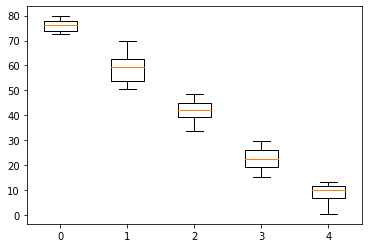

boxplot for industry_a


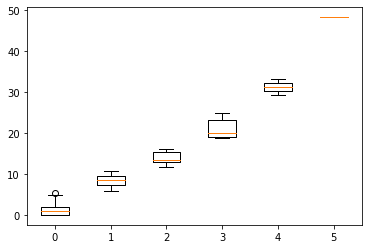

boxplot for commercial_a


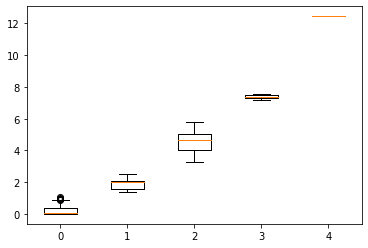

boxplot for nightlife


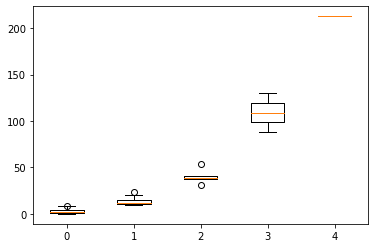

boxplot for foodstores


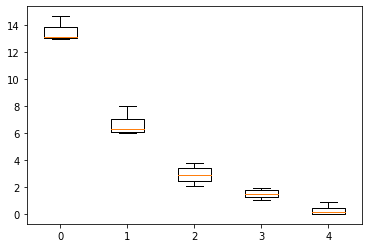

boxplot for health


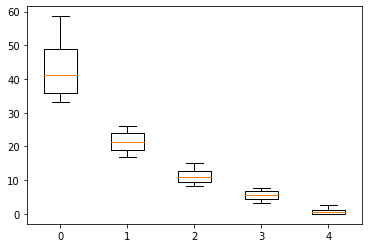

boxplot for transport


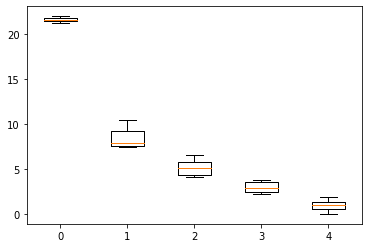

boxplot for citiziens/km2


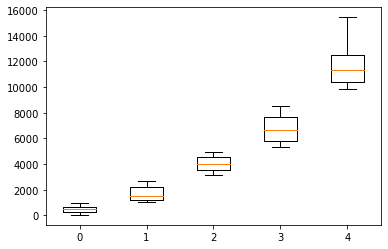

In [35]:
#iterate all columns and for each column show boxplot
for col in districts_clustered.columns:
    
    #merge clusters of current column with it's values side by side
    clst_and_val = pd.merge(districts_clustered[[col]],districts_with_zones_clst[[col]],left_index=True,right_index=True)
    clst_and_val.columns = ['clst','val']
    
    #group by so that on each row there is one cluster and list of it's corresponding values
    clst_and_val = clst_and_val.groupby('clst')['val'].agg(list)
    
    #show in boxplot
    print('boxplot for {}'.format(col))
    plt.boxplot(clst_and_val,labels=clst_and_val.index)
    plt.show()

Note that some clusters are sorted from highest medians to lowest, and some from lowest medians to highest. That's because we reordered clusters labels to have some ordinal meaning, so that we can say that lowest cluster number means best median value of given feature.

### 6) Getting best districts
Now we have everything what we need - all data downloaded and clustered, and the only one thing which we need to do, is to find out, whether there are some districts, which are in best clusters of each feature. So let's create code which will define that, and find out whether some good districts exist.

In [36]:
separate_best_groups = []

#iterate columns and keep districts which are in best clusters.
for col in districts_clustered.columns:
    
    #select best cluster - the one with lowest value
    best_clst = min(districts_clustered[col])
        
    #select districts which has only the best cluster label for given feature
    selected_districts = districts_clustered[col][districts_clustered[col] == best_clst].index.tolist()
    separate_best_groups.append(set(selected_districts))

#try to find intersection and show which districts matches best conditions
set.intersection(*separate_best_groups)

set()

Well... We have found out that there is no such district matching all the critera. But in real life, nothing is ideal, and we always have to do compromises. Thats gonna be same in this situation. What we clearly know is that we will have to try to find some districts, that matches our criteria as much as possible. But how to do that?

#### 6.1) Searching for intersection with weighted conditions

At this moment, we need to set priorities. We must tell, which conditions or features we used are more cruical and which less. I know this is mostly product decision, again based on knowledge of the problem domain, but we have to do it.

Let's take a look at conditions we have so far:
- nature area: I think this is quite important condition, because it directly affects how the environment around you looks, and what activities you can do close to your home. Especially, if you are senior, this is something you would care about.
- industry area: This is also important: Although it is connected with nature area condition, it's not redundant with it, as we do not include some other types of areas. That means, that if there is 70% of district park, it is still huge difference, whether the rest 30% is nuclear power plant, or group of family houses.
- nightlife: As this includes also hotels, this is also important, because it's just another factor that specifies the feel that you get from the district. Do you see lot of young drunk tourists, or just young families? That's a big difference.
- citiziens/km2: Also too many people per square kilometer can be source of noise and problem. However, people living around you is not so exact negative factor as too much industry, lack of nature, or too many hotels and bars.
- foodtores and health: These are also important and directly affects quality of life, but they are not so important in the meaning of their amount - usually it is important to have at least _some_ foodstore or at least some pharmacy in the district, but it's not a big difference if there is 10 or 20 foodstores, in terms of quality of life.
- transport: As we can expect that if seniors have money to buy apartment, they will also have money to car, this is less important, but still not totally unimportant. Not everyone has car, and public transport is sometimes much more comfortable.
- commercial area: That is probably least important - it is still better to have office house next to your appartment, than hotel or factory.

From above mentioned, i decided to set priorities for our features as following (1. is top priority, 4. is lowest):
1. nature area, nightlife, industry area
2. citiziens/km2
3. foodstores, health, transport
4. commercial area

----------
Now, instead of manually setting which values are less or more important, we create a function, which will iterate and select all districts matching our condition, and if it won't find any, it accepts even worse cluster from lowest priority condition. If it still won't find any, it accept's even the worse cluster for that feature and so on.

For example we have features A,B,C,D with descending priorities (A is the highest priority). Now we select best cluster from A. Then we select best cluster from B. If there is no intersection between the clusters, we select second best cluster from B, and again we check interesection. If there is still no intersection, we select the third best cluster, and so on. Then we go to C. We select best cluster and check whether there is intersection with previously selected data. If there is, we go to D, otherwise, we accept also the second best cluster from C, like we did in case of B. The same applies for D.

------------
Or we can use more complex algorithm. Let's say we have vector of features and it's corresponding vector of priorities:

-|-|-|-|-|-
---|---|---|---|---|---
Feature|A|B|C|D|E
Priority|1|2|3|4|5

Now imagine that each priority is not just priority, but it is also weight which is proportiaonaly equal to _n*10_ of allowed clusters percentage for current feature. I will explain with following table:

-|-|-|-|-|-
---|---|---|---|---|---
Feature|A|B|C|D|E
Priority|1|2|3|4|5
Accepted % best clusters|10%|20%|30%|40%|50%

I will add also number of accepted best clusters for each feature. Imagine that each feature has 10 clusters:

-|-|-|-|-|-
---|---|---|---|---|---
Feature|A|B|C|D|E
Priority|1|2|3|4|5
Accepted % best clusters|10%|20%|30%|40%|50%
Accepted # best clusters|1|2|3|4|5

The table actually shows distribution of allowed clusters over different priorities. This means that last line Accepted # best clusters can be for example also 0.5, 1, 1.5, 2, 2.5, therefore 1,1,2,2,3 (because we can accept only whole cluster not half of it).

Actually, __this can be written as a following function__: `f(x,t) = (min(x/10,1))*t` where _x_ is priority, _t_ is tolerance level, and function output is ratio of allowed clusters. Example: we have feature C with priority 3, and we set tolerance to 0.75. The function result is `min(3/10,1)*0.75 = 0.225 = 22.5%`. This means that for feature C we accept roughly 22.5% of best clusters. If there would be 10 clusters we would accept 2 best clusters. The `min` function in formula is used just to ensure that we don't allow more than 100% of clusters, which indeed is not possible.

However, how to determine `t` parameter? If you think about it, the lower the `t` is, the lower is number of accepted clusters. Therefore to get best result, we should try to use different `t` values, from lowest to highest, and once we find intersection of some clusters, we found the desired result. We can say that __objective is to find lowest possible `t` for which at least one intersection between selected clusters exists__.

We could also use different function than the one above, if we wanted the weights to be differently distributed.

For example `f(x,t) = (min(((2**x)/2)/10,1))*t` with `t = 1` and _x_ is priority, would be create following table (with 10 clusters):

-|-|-|-|-|-
---|---|---|---|---|---
Feature|A|B|C|D|E
Priority|1|2|3|4|5
Accepted % best clusters|10%|20%|40%|80%|100%
Accepted # best clusters|1|2|4|8|10

But this was just for example. We will use our original function `f(x,t) = (min(x/10,1))*t`.

---------------------

Now it's time to write an function which will try different `t` values from lowest to highest, and returns the lowest possible `t` which gives us some intersection between all above conditions.

In [37]:
#define features and priorities. Each item in priorities_list refers to priority of feature on same index in features_list
features_list = ['nature_a','citiziens/km2','nightlife','foodstores','health','industry_a','transport','commercial_a']
weighting_function = lambda x,t: (min((x)/10,1))*t
priorities_list = [1,2,1,2,2,1,2,3]
priorities_list = [1,2,1,3,3,1,3,4]
#weighting_function = lambda x,t: (min(x/10,1))*t
tvals = [val/20 for val in range(0,100)]

def find_best_t(df,f,p,wf,tvals):
    """
    finds lowest possible t for which some intersection exists
    df: dataframe with clusters values
    f: list of features
    p: list of priorities according to order of list of features
    wf: weighting function
    tvals: all tolerance values of t to try. It will be tried from lowest to highest
    """
    output = []
    
    #vectorize weighting function (this allows to compute all ratios for all different thresholds at once)
    wf = np.vectorize(wf)
    
    #try different tolerances
    for tol in tvals:
        ratios_of_allowed_clsts = wf(p,tol)
        clsts_per_feat = [len(df[feat].unique()) for feat in f]
        numbers_of_allowed_clsts = (np.array(clsts_per_feat)*np.array(ratios_of_allowed_clsts)).round()+1
        
        #select data
        selected_from_feature = []
        for feat,clsts in zip(f,numbers_of_allowed_clsts):
            selected_districts = df[df[feat] < clsts].reset_index()['district'].tolist()
            selected_from_feature.append(set(selected_districts))
            
        #get intersection of selected districts for current tolerance
        final_selected = set.intersection(*selected_from_feature)
        
        #append stats to output
        output.append([tol,ratios_of_allowed_clsts,numbers_of_allowed_clsts,len(final_selected),final_selected])
        
    return pd.DataFrame(output,columns=['tolerance','ratios','# of allowed clsts','# of selected dists','selected dists'])

#run the function
selected = find_best_t(districts_clustered,features_list,priorities_list,weighting_function,tvals)

#select only rows where at least one district is included
selected[selected['# of selected dists'] > 0][['tolerance','# of allowed clsts','# of selected dists','selected dists']]

,tolerance,# of allowed clsts,# of selected dists,selected dists
34,1.70,"[2.0, 3.0, 2.0, 4.0, 4.0, 2.0, 4.0, 4.0]",9,"{Vokovice, Modřany, Dejvice, Braník, Hradčany,..."
35,1.75,"[2.0, 3.0, 2.0, 4.0, 4.0, 2.0, 4.0, 5.0]",9,"{Vokovice, Modřany, Dejvice, Braník, Hradčany,..."
36,1.80,"[2.0, 3.0, 2.0, 4.0, 4.0, 2.0, 4.0, 5.0]",9,"{Vokovice, Modřany, Dejvice, Braník, Hradčany,..."
37,1.85,"[2.0, 3.0, 2.0, 4.0, 4.0, 2.0, 4.0, 5.0]",9,"{Vokovice, Modřany, Dejvice, Braník, Hradčany,..."
38,1.90,"[2.0, 3.0, 2.0, 4.0, 4.0, 2.0, 4.0, 5.0]",9,"{Vokovice, Modřany, Dejvice, Braník, Hradčany,..."
...,...,...,...,...
95,4.75,"[3.0, 6.0, 3.0, 8.0, 8.0, 4.0, 8.0, 11.0]",66,"{Vinohrady, Břevnov, Řepy, Vyšehrad, Hrdlořezy..."
96,4.80,"[3.0, 6.0, 3.0, 8.0, 8.0, 4.0, 8.0, 11.0]",66,"{Vinohrady, Břevnov, Řepy, Vyšehrad, Hrdlořezy..."
97,4.85,"[3.0, 6.0, 3.0, 8.0, 8.0, 4.0, 8.0, 11.0]",66,"{Vinohrady, Břevnov, Řepy, Vyšehrad, Hrdlořezy..."
98,4.90,"[3.0, 6.0, 3.0, 8.0, 8.0, 4.0, 8.0, 11.0]",66,"{Vinohrady, Břevnov, Řepy, Vyšehrad, Hrdlořezy..."


In the dataframe above, we see results for different tolerance values. Now we select best results, with at least 3 districts.

In [38]:
res = selected[selected['# of selected dists'] > 3][['tolerance','# of allowed clsts','selected dists','# of selected dists']]
res = res.reset_index().loc[0:0,:]
res

,index,tolerance,# of allowed clsts,selected dists,# of selected dists
0,34,1.7,"[2.0, 3.0, 2.0, 4.0, 4.0, 2.0, 4.0, 4.0]","{Vokovice, Modřany, Dejvice, Braník, Hradčany,...",9


We can see that number of selected districts is 9. Also in column _# of allowed clsts_ we see how many n best clusters were accepted for each feature. The order of items in list, is same like the order of features in _features_list_ variable, so let's print it together, so that we see how many n best clusters were allowed in each feature. Also we will attach information about how many clusters each feature has (to get some relative insight).

In [39]:
print('list of selected districts, that best matches our conditions: ')
display(res['selected dists'].tolist()[0])

#now we print what clusters were accept for which feature, and what was worst accepted value
results = []
for feat,number_allowed in zip(features_list,res['# of allowed clsts'][0]):
    total_number_of_clsts = len(districts_clustered[feat].unique())
    results.append([feat,int(number_allowed),int(total_number_of_clsts),(int(number_allowed)/int(total_number_of_clsts))*100])
    
results = pd.DataFrame(results,columns=['feature_name','# of allowed clusters','# of total clusters','% of allowed clusters'])
print('statistic of allowed best n clusters for each feature:')
display(results)

list of selected districts, that best matches our conditions: 


{'Braník',
 'Břevnov',
 'Dejvice',
 'Hlubočepy',
 'Hradčany',
 'Košíře',
 'Libeň',
 'Modřany',
 'Vokovice'}

statistic of allowed best n clusters for each feature:


,feature_name,# of allowed clusters,# of total clusters,% of allowed clusters
0,nature_a,2,5,40.000000
1,citiziens/km2,3,5,60.000000
2,nightlife,2,5,40.000000
3,foodstores,4,5,80.000000
4,health,4,5,80.000000
5,industry_a,2,6,33.333333
6,transport,4,5,80.000000
7,commercial_a,4,5,80.000000


What we can see in the table above? We set highest priorities to size of nature landscape, nightlife and industry area, so these were most prioritized, which means that worst possible cluster accepted is 2 of 5 or 6 (recall that 1 = best values, 5 or 6 = worst values). For the mid-priority and low-priority features, approximatelly 60 to 80% of clusters is accepted.

### 6) Conclusion
Let's show our selected districts on map:

In [40]:
from folium.map import Popup
fmap = folium.Map(location=(lat,lng),zoom_start=11)

for sel in res['selected dists'].tolist()[0]:
    polygon = districts.loc[sel,'polygon']
    
    #get table of statistic about current district
    data = districts_with_zones_clst.loc[sel]
    pop = Popup(rem_dia(pd.DataFrame(data).to_html()),parse_html=False)
    
    #add to map
    poly = folium.vector_layers.Polygon(polygon,color='black',tooltip=rem_dia(sel),popup=pop,parse_html=True,fill=True,fillcolor='gray')
    poly.add_to(fmap)

fmap

Now if you hover over map and click on each district, you can see it's values for each feature. Just to recall:
 - nightlife, health, and foodstores, and transport (public traffic stations) are in units _number of venues per square km
 - nature_a, industry_a, commercial_a use units % of district area
 - citiziens/km2 means number of citiziens per square km

If you check districts, you can see that there are still at least some stores, while keeping enough nature and calm areas. So what we can finally tell about the results?
 - desired districts are usually not directly in the city center, due to it's noisy environment
 - on the other hand city borders does not provide important facilites like bus stops, stores, and also most of the land is not parks or forests, but agricultural land
 - no district is perfect: this means, always we have to tolerate same tradeoffs: for example some of districts have really high population density, so there may be already apartments; however, if we would select another, with lower population density, there would be no foodstores, because - as expected - foodstores are only in places where enough people live.
 
----------

That's all. Thank you for your patience with this notebook, hope you like it! (-: